In [1]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import numpy.linalg as LA
from scipy import integrate
from numba import jit, njit

In [2]:
from algorithms.meshforrectangle import MeshForRectangle

In [3]:
w = 1
h = 2
rectangle = [[0,0],[0,h],[w,h],[w,0]]
rectangle_area = h*w

u = lambda x, y: (x - 1)**2 * (y - 2)**2 *x*y
du_dx1 = lambda x, y: (-1 + x) * (-1 + 3*x) * (-2 + y)**2 * y
du_dx2 = lambda x, y: (-1 + x)**2 * x * (-2 + y) * (-2 + 3*y)

a11 = 1
a22 = 1

d = 0

#f = lambda x, y: 3 

f = lambda x, y: 2*(-2+3*x)*(-2+y)**2*y+2*(-1+x)**2*x*(-4+3*y)

beta = 1e-10
sigma = 1e+10
psi = 0

In [4]:
nx = 16
ny = 32
mesher = MeshForRectangle(nx, ny)
triangulation = list(map(lambda t: t.get_points(), mesher.triangulate(rectangle)))

In [5]:
triangulation

[[[0, 0], [0.0625, 0.0625], [0, 0.0625]],
 [[0, 0], [0.0625, 0], [0.0625, 0.0625]],
 [[0, 0.0625], [0.0625, 0.125], [0, 0.125]],
 [[0, 0.0625], [0.0625, 0.0625], [0.0625, 0.125]],
 [[0, 0.125], [0.0625, 0.1875], [0, 0.1875]],
 [[0, 0.125], [0.0625, 0.125], [0.0625, 0.1875]],
 [[0, 0.1875], [0.0625, 0.25], [0, 0.25]],
 [[0, 0.1875], [0.0625, 0.1875], [0.0625, 0.25]],
 [[0, 0.25], [0.0625, 0.3125], [0, 0.3125]],
 [[0, 0.25], [0.0625, 0.25], [0.0625, 0.3125]],
 [[0, 0.3125], [0.0625, 0.375], [0, 0.375]],
 [[0, 0.3125], [0.0625, 0.3125], [0.0625, 0.375]],
 [[0, 0.375], [0.0625, 0.4375], [0, 0.4375]],
 [[0, 0.375], [0.0625, 0.375], [0.0625, 0.4375]],
 [[0, 0.4375], [0.0625, 0.5], [0, 0.5]],
 [[0, 0.4375], [0.0625, 0.4375], [0.0625, 0.5]],
 [[0, 0.5], [0.0625, 0.5625], [0, 0.5625]],
 [[0, 0.5], [0.0625, 0.5], [0.0625, 0.5625]],
 [[0, 0.5625], [0.0625, 0.625], [0, 0.625]],
 [[0, 0.5625], [0.0625, 0.5625], [0.0625, 0.625]],
 [[0, 0.625], [0.0625, 0.6875], [0, 0.6875]],
 [[0, 0.625], [0.0625, 0

In [6]:
points = np.unique(np.concatenate(triangulation), axis=0).tolist()
triangles = list(map(lambda tri: [points.index(tri[0]),
                                  points.index(tri[1]),
                                  points.index(tri[2]),], triangulation))

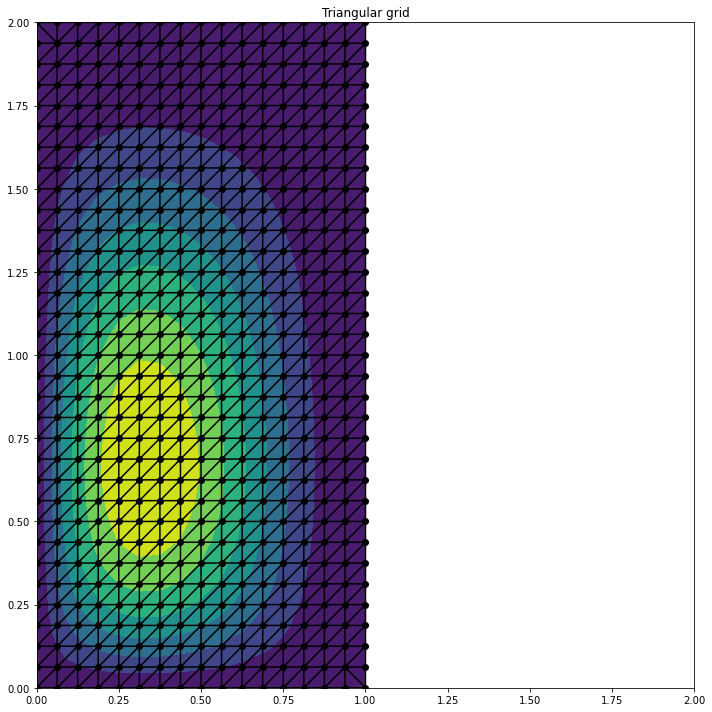

In [7]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
ax.tricontourf(triang, z)
ax.triplot(triang, 'ko-')
ax.set_title('Triangular grid')

fig.tight_layout()
plt.savefig('s.pdf')
plt.show()

In [8]:
n =  len(triangles)
triangle_area = rectangle_area / n
s = triangle_area

def K_i(b, c, s, a11, a22):
    K = np.zeros([3, 3])
    for i in range(3):
        for j in range(3):
            K[i][j] = (a11 * (b[i] * b[j]) + a22 * (c[i] * c[j]))

    K = K / (2 * 2 * s)
    return K


def fill_A_with_K_i(A, K, tri):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += K[i][j]  
    
def fill_A_with_M_i(A, M, tri, d):
    for i in range(3):
        for j in range(3):
            A[tri[i]][tri[j]] += d * M[i][j]   
            
def fill_F_with_phi_i(F, tri, points, M):
    Qe = np.zeros(3);
    Me = np.sum(M,axis=1)
    for i in range(3):
        Qe[i] = -Me[i] * f(*points[tri[i]])

    for i in range(3):
        F[tri[i]] += Qe[i]


In [9]:
G = h / ny

Re = (sigma*G)/(6*beta) * np.array([[2, 1], [1, 2]])
Pe = (psi*G)/(2*beta) * np.array([1, 1])
Me = (s)/(12) * np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])

a = np.zeros([n, 3])
b = np.zeros([n, 3])
c = np.zeros([n, 3])
phi = np.zeros([n, 3])

A = np.zeros([len(points), len(points)])
F = np.zeros([len(points), 1])
not_boundary = []

for i, tri in enumerate(triangles):
    
    p1 = points[tri[0]]
    p2 = points[tri[1]] 
    p3 = points[tri[2]]
    
    boundary_points = np.array([])
    if sum(np.array([p1[0], p2[0], p3[0]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == 0]
    elif sum(np.array([p1[0], p2[0], p3[0]]).round(5) == w) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 0] == w]        
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == 0) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == 0]
    elif sum(np.array([p1[1], p2[1], p3[1]]).round(5) == h) == 2:
        l = np.array([p1, p2, p3])
        boundary_points = l[l[:, 1] == h]

    if boundary_points.size:

        boundary_points = boundary_points.tolist()
        if p2 not in boundary_points:
            boundary_points.reverse()

        A[points.index(boundary_points[0])][points.index(boundary_points[0])] += Re[0][0]
        A[points.index(boundary_points[0])][points.index(boundary_points[1])] += Re[0][1]
        A[points.index(boundary_points[1])][points.index(boundary_points[0])] += Re[1][0]
        A[points.index(boundary_points[1])][points.index(boundary_points[1])] += Re[1][1]
        
        F[points.index(boundary_points[0])] += Pe[0]
        F[points.index(boundary_points[1])] += Pe[1]   

    groups = [
        (p2, p3, _), (p3, p1, _), (p1, p2, _)
    ]
    
    for j, group in enumerate(groups):
        tm = group[0] # m
        tj = group[1] # j
        
        #a[i][j] = t1[0]*t1[1] - t2[0]*t2[1]
        a[i][j] = tj[0]*tm[1] - tm[0]*tj[1]
        
        b[i][j] = tj[1] - tm[1]
        c[i][j] = tj[0] - tm[0]
        
    K = K_i(b[i], c[i], s, a11, a22)
    fill_A_with_K_i(A, K, tri)
    fill_A_with_M_i(A, Me, tri, d)
    fill_F_with_phi_i(F, tri, points, Me)

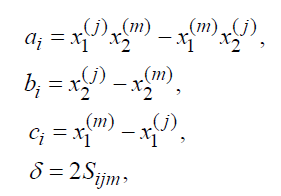

In [10]:
a

array([[-0.00390625,  0.        ,  0.        ],
       [-0.00390625,  0.        ,  0.        ],
       [-0.0078125 ,  0.        ,  0.00390625],
       ...,
       [-0.0625    , -0.05859375,  0.1171875 ],
       [-0.125     ,  0.05859375,  0.0625    ],
       [-0.0625    , -0.0625    ,  0.12109375]])

In [11]:
u_approx = LA.solve(A, F)

In [12]:
ex = [u(*p) for p in points]

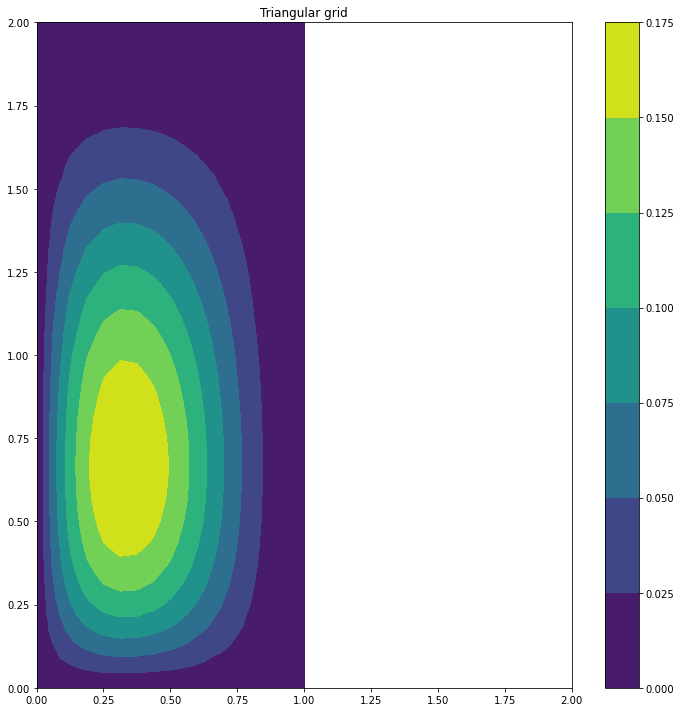

In [13]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u_approx.ravel()

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)

ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

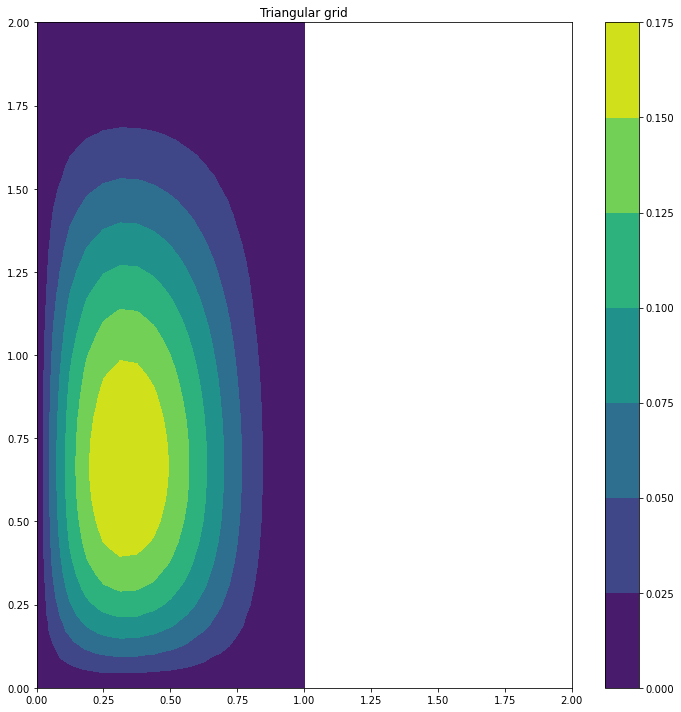

In [14]:
x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

triang = mtri.Triangulation(x, y, triangles)

# Interpolate to regularly-spaced quad grid.
z = u(x,y)

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))

plt.xlim(0, h)
plt.ylim(0, h)

# Plot the triangulation.
cp = ax.tricontourf(triang, z)
fig.colorbar(cp)
ax.set_title('Triangular grid')


fig.tight_layout()
plt.show()

In [15]:
def show_success(index):
    point_index = int(len(points) * index)

    print("Exact solution: \t", ex[point_index])
    print("Approximate solution: \t", u_approx[point_index])
    print("Error: \t\t\t", np.abs(ex[point_index] - u_approx[point_index][0]))
    print('{:.2e}'.format(np.abs(ex[point_index] - u_approx[point_index][0])))
    print()


In [16]:
for coef in [0, 0.1, 0.57, 0.81]:
    show_success(coef)

Exact solution: 	 0.0
Approximate solution: 	 [-1.36861935e-21]
Error: 			 1.3686193515501874e-21
1.37e-21

Exact solution: 	 0.024984776973724365
Approximate solution: 	 [0.02498457]
Error: 			 2.0220147969179925e-07
2.02e-07

Exact solution: 	 0.057828426361083984
Approximate solution: 	 [0.05782803]
Error: 			 3.9207717397043984e-07
3.92e-07

Exact solution: 	 0.008542835712432861
Approximate solution: 	 [0.00854265]
Error: 			 1.860880072326876e-07
1.86e-07



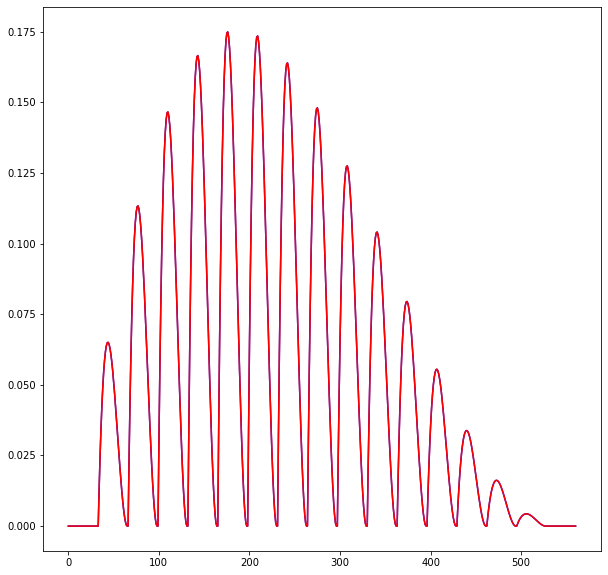

In [17]:
mesh = range(len(u_approx))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(mesh, ex, 'blue')
ax.plot(mesh, u_approx, 'red')


In [18]:
u_approx = u_approx.ravel()

In [19]:
def segment_volume(h1, h2, h3, s=triangle_area):
    return s*(h1+h2+h3)/3

In [20]:
def dbl_integ(u, triangles):
    '''
    :param u: array
    '''
    integral = 0
    for (p1, p2, p3) in triangles:
        
        integral += segment_volume(u[p1], u[p2], u[p3])
        
    return integral

In [21]:
def norm_L2(u, triangles):
    '''
    :param u: array
    '''
    return np.sqrt(dbl_integ(u**2, triangles))

In [22]:
err_abs_L2 = norm_L2(u(x, y)-u_approx, triangles)
err_abs_L2

6.211856443248621e-06

In [23]:
err_rel_L2 = err_abs_L2/norm_L2(u(x, y), triangles) * 100
err_rel_L2

0.005765248120691391

## The end of working code. None of us is responsible for the results obtained below.

Wasserstein distance:
$$\|u(x)\|_{W_{2}^{(1)}}^{2}=\int_{\Omega}\left(u(x)^{2}+\frac{\partial u(x)^{2}}{\partial x_{1}}+\frac{\partial u(x)^{2}}{\partial x_{2}}\right) d \Omega$$

In [24]:
def norm_W2(u, du_dx1, du_dx2):
    '''
    :param u: function
    '''
    u_ = lambda x, y: u(x, y)**2 + du_dx1(x, y)**2 + du_dx2(x, y)**2
    
    return np.sqrt(integrate.dblquad(u_, 0, h, lambda t: 0, lambda t: w)[0])

In [25]:
def draw_triangle(index):
  x, y = [l.ravel() for l in np.split(points, [-1], axis=1)]

  triang = mtri.Triangulation(x, y, triangles[index:index+1])

  # Set up the figure
  fig, ax = plt.subplots(figsize=(10,10))

  plt.xlim(0, h)
  plt.ylim(0, h)

  # Plot the triangulation.
  ax.triplot(triang, 'ko-')
  ax.set_title('Triangular grid')

  fig.tight_layout()
  plt.savefig('s.pdf')
  plt.show()

In [26]:
h_step = w/nx
v_step = h/ny
(h_step, v_step)

(0.0625, 0.0625)

In [27]:
@jit
def get_triangle_index_by_point(x, y):
  
  if x == w:
    column = 2*ny*(x//h_step - 1)
  else:
    column = 2*ny*(x//h_step)
  
  
  if y == h:
    row = y//v_step * 2 - 1
  else:
    row = y//v_step * 2
    

  triangle_index = column + row
  
  if x%h_step > y%v_step:
    triangle_index += 1
  
  return int(triangle_index)

1023


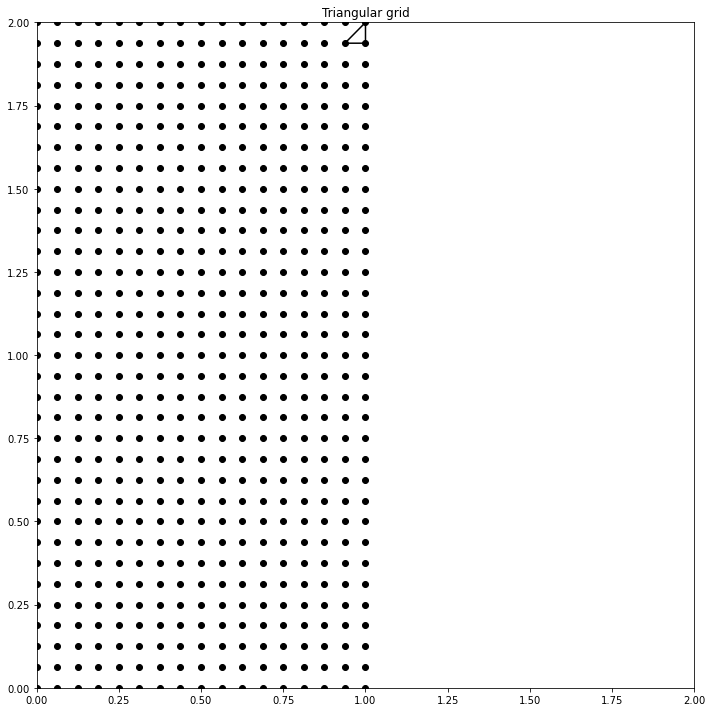

In [28]:
index = get_triangle_index_by_point(1, 2)
print(index)
draw_triangle(index)

$$
\varphi_{i}^{(e)}\left(x_{1}^{(i)}, x_{2}^{(i)}\right)=\frac{1}{\delta}\left(c_{i} x_{2} - b_{i} x_{1} - a_{i}\right)
$$

$$u_{h}=u_{i}^{h} \varphi_{i}^{(e)}\left(x_{1}, x_{2}\right)+u_{j}^{h} \varphi_{j}^{(e)}\left(x_{1}, x_{2}\right)+u_{m}^{h} \varphi_{m}^{(e)}\left(x_{1}, x_{2}\right)$$

$$\frac{\partial u(x)}{\partial x_{1}}=
  -\frac{1}{\delta}(u_{i}^{h}b_i
+u_{j}^{h}b_j
+u_{m}^{h}b_m)$$

$$\frac{\partial u_h(x)}{\partial x_{2}}=
  \frac{1}{\delta}(u_{i}^{h}c_i
+u_{j}^{h}c_j
+u_{m}^{h}c_m)$$

In [29]:
@jit
def u_approx_cont(x, y, triangles=np.array(triangles)):
  triangle_index = get_triangle_index_by_point(x, y)

  p1, p2, p3 = triangles[triangle_index]
  
  delta = 2*s
  
  phis = [(c[triangle_index][i]*y - b[triangle_index][i]*x - a[triangle_index][i]) / delta for i in range(3)]
   
  u_approx_result = float(u_approx[p1]*phis[0] + u_approx[p2]*phis[1] + u_approx[p3]*phis[2])
  
  return u_approx_result

In [30]:
@jit
def du_approx_cont_dx1(x, y, triangles=np.array(triangles), u_approx=u_approx):
  
  triangle_index = get_triangle_index_by_point(x, y)

  p1, p2, p3 = triangles[triangle_index]
  
  delta = 2*s
   
  du_approx_result = -(u_approx[p1]*b[triangle_index][0] \
                     + u_approx[p2]*b[triangle_index][1] \
                     + u_approx[p3]*b[triangle_index][2] ) / delta
  
  return du_approx_result

In [31]:
@jit    
def du_approx_cont_dx2(x, y, triangles=np.array(triangles), u_approx=u_approx):
  
  triangle_index = get_triangle_index_by_point(x, y)

  p1, p2, p3 = triangles[triangle_index]
  
  delta = 2*s
   
  du_approx_result = ( u_approx[p1]*c[triangle_index][0] \
                     + u_approx[p2]*c[triangle_index][1] \
                     + u_approx[p3]*c[triangle_index][2] ) / delta
  
  return du_approx_result

In [37]:
@jit
def diff_u(x, y, u=u, u_approx_cont=u_approx_cont):
  a = u(x, y) - u_approx_cont(x, y)
  return a

@jit
def diff_du_dx1(x, y, u=u, du_approx_cont_dx1=du_approx_cont_dx1):
  a = du_dx1(x, y) - du_approx_cont_dx1(x, y)
  return a

@jit
def diff_du_dx2(x, y, u=u, du_approx_cont_dx2=du_approx_cont_dx2):
  a = du_dx2(x, y) - du_approx_cont_dx2(x, y)
  return a

In [38]:
err_abs_W2 = norm_W2(diff_u,
                     diff_du_dx1,
                     diff_du_dx2)
err_abs_W2

<ipython-input-37-d5a7bd8f0337>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "diff_u" failed type inference due to: Internal error at <numba.core.typeinfer.ArgConstraint object at 0x000001EC330C7880>.
Cannot determine Numba type of <class 'function'>
During: typing of argument at <ipython-input-37-d5a7bd8f0337> (3)
Enable logging at debug level for details.

File "<ipython-input-37-d5a7bd8f0337>", line 3:
def diff_u(x, y, u=u, u_approx_cont=u_approx_cont):
  a = u(x, y) - u_approx_cont(x, y)
  ^

  @jit
c:\users\bobuh\appdata\local\programs\python\python38\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "diff_u" was compiled in object mode without forceobj=True.

File "<ipython-input-37-d5a7bd8f0337>", line 2:
@jit
def diff_u(x, y, u=u, u_approx_cont=u_approx_cont):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
c:\users\bobuh\appdata\local\programs\python\python38\lib\site-packages\numba\core\ob

KeyboardInterrupt: 

In [ ]:
err_rel_W2 = err_abs_W2/norm_W2(u, du_dx1, du_dx2) * 100
err_rel_W2

In [ ]:
def norm_L2(u):
    '''
    :param u: array
    '''
    return np.sqrt(integrate.dblquad(u, 0, h, lambda t: 0, lambda t: w)[0])

In [ ]:
# 0.04640924963661859
err_abs_L2 = norm_L2(lambda x, y: u(x, y)-u_approx_cont(x, y))
err_abs_L2

In [ ]:
err_rel_L2 = err_abs_L2/norm_L2(u) * 100
err_rel_L2

## Dead code

In [ ]:
#test_point = (0.33, 0.2)

#test_point = (0.7, 0.5)

#test_point = (0.1, 0.1)

test_point = (0.5, 1)

In [ ]:
u_approx_cont_array = []
for (i, j) in zip(x, y):
  u_approx_cont_array.append(u_approx_cont(i, j))

In [ ]:
dbl_integ(u(x, y), triangles)

In [ ]:
dbl_integ(u_approx_cont_array, triangles)

In [ ]:
integrate.dblquad(u, 0, 2, lambda t: 0, lambda t: 1)[0]

In [ ]:
integrate.dblquad(u_approx_cont, 0, 2, lambda t: 0, lambda t: 1)[0]